CLASSIFICATION TREE - IRIS DATASET

Our Tree Structure:
Root Depth 0: samples=120, impurity=1.5811, prediction=2
     Class counts: {np.int64(0): np.int64(39), np.int64(1): np.int64(37), np.int64(2): np.int64(44)}
     Split at x <= 5.8000
    ├─L─ Depth 1: samples=59, impurity=1.0828, prediction=0
         Class counts: {np.int64(0): np.int64(39), np.int64(1): np.int64(18), np.int64(2): np.int64(2)}
         Split at x <= 5.4000
    │   ├─L─ Depth 2: samples=39, impurity=0.6450, prediction=0
    │        Class counts: {np.int64(0): np.int64(34), np.int64(1): np.int64(4), np.int64(2): np.int64(1)}
    │        Split at x <= 4.9000
    │   │   ├─L─ Depth 3: samples=15, impurity=0.3534, prediction=0
    │   │        Class counts: {np.int64(0): np.int64(14), np.int64(2): np.int64(1)}
    │   │        Split at x <= 4.9000
    │   │   │   ├─L─ Depth 4: samples=13, impurity=0.0000, prediction=0
    │   │   │        Class counts: {np.int64(0): np.int64(13)}
    │   │   │   └─R─ Depth 4: sampl

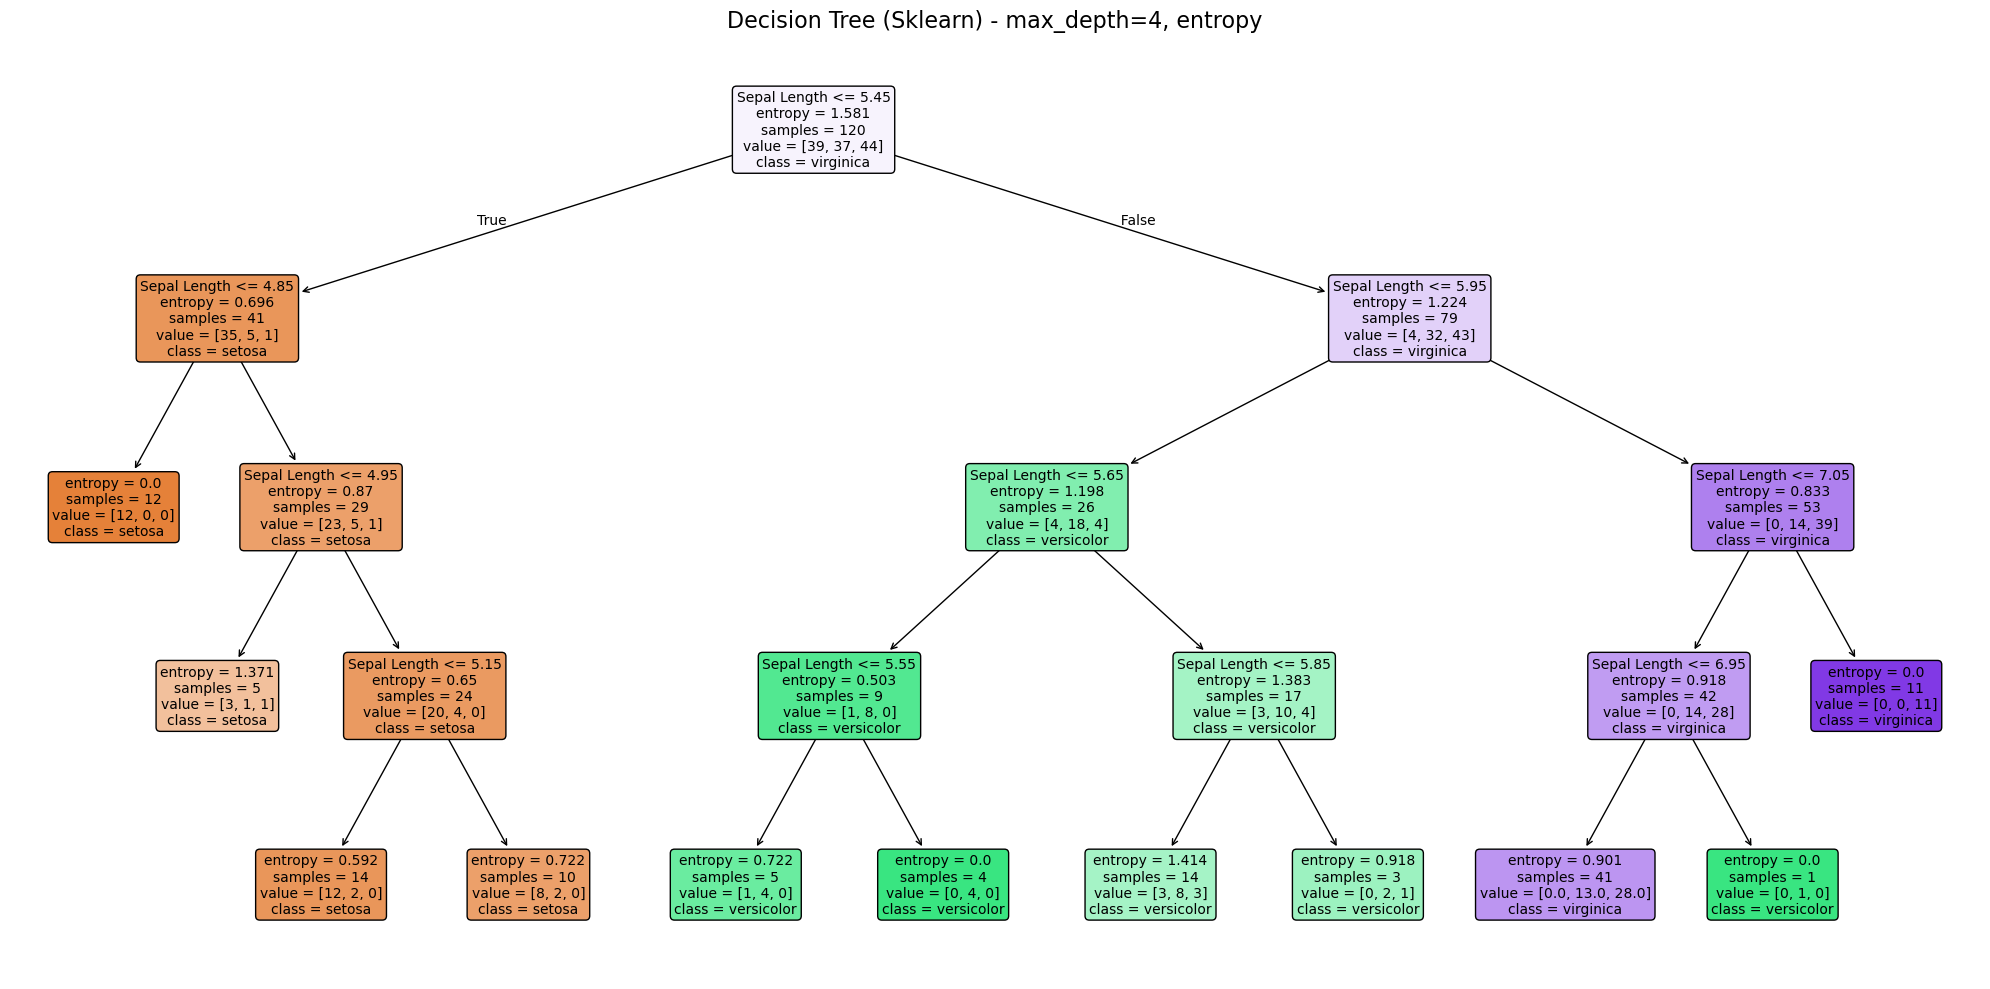

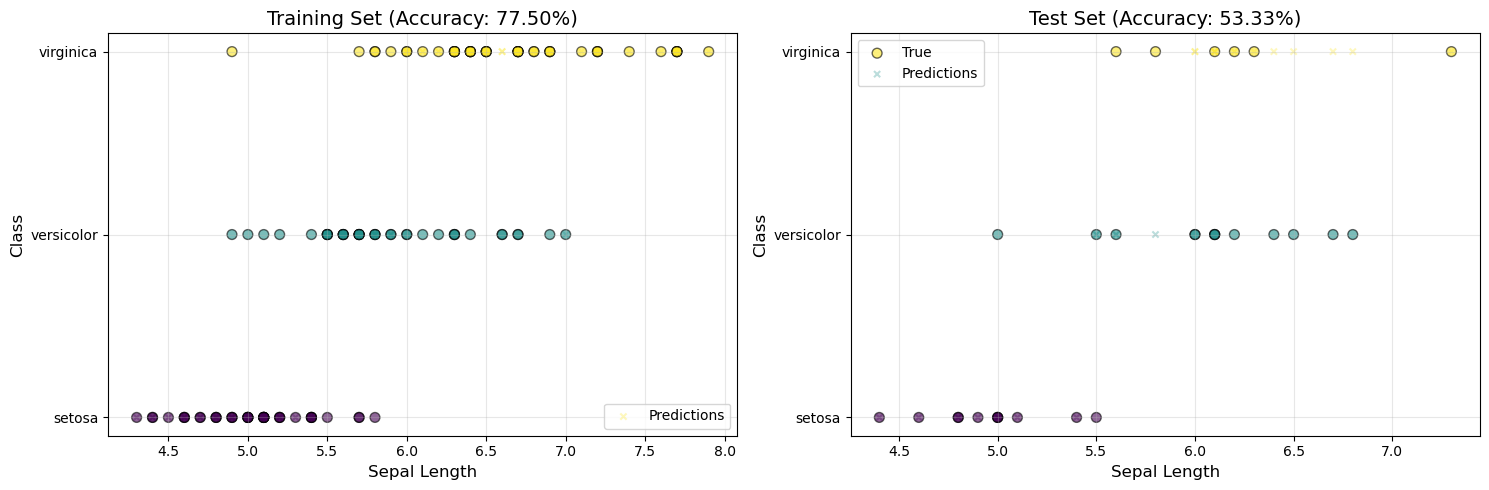

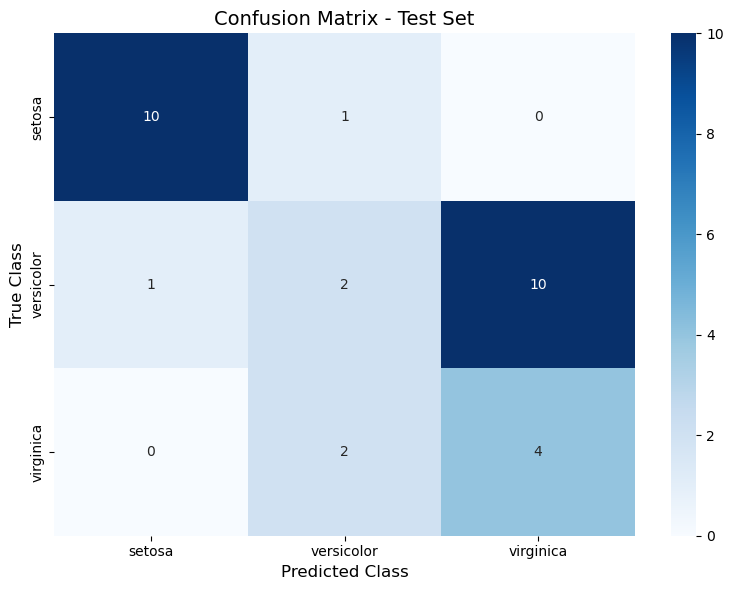


BONUS: Comparing Entropy vs Gini Criterion


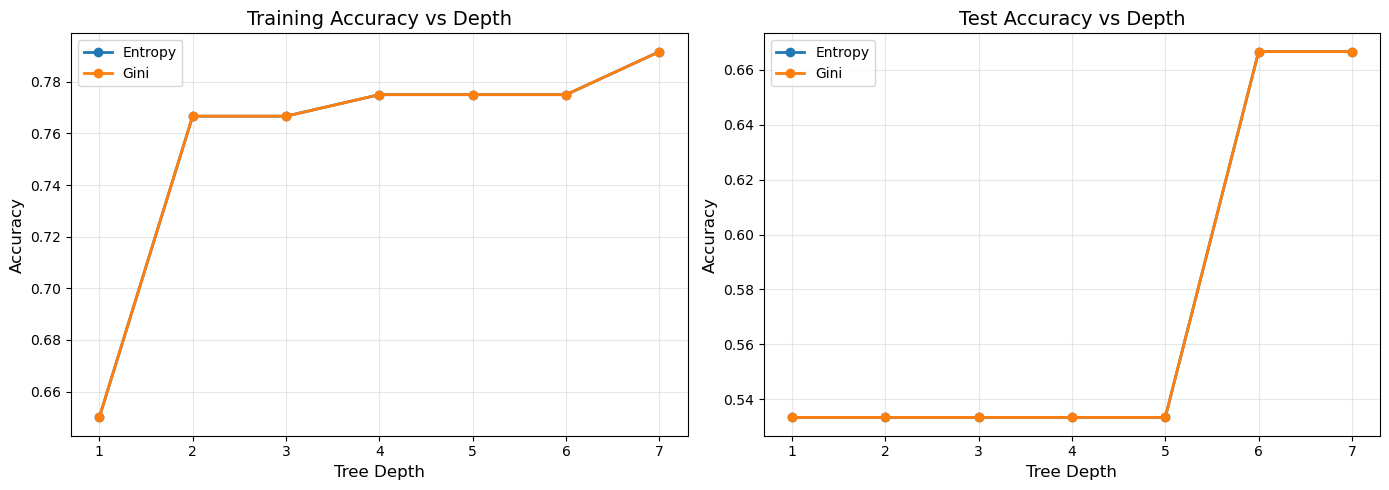


All visualizations saved!
- iris_tree_structure.png
- iris_predictions.png
- iris_confusion_matrix.png
- iris_criterion_comparison.png


In [1]:
# Q4

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Classification Tree Implementation with Iris Dataset
Compares custom implementation with sklearn DecisionTreeClassifier
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

class ClassificationNode:
    """Node for classification tree"""
    
    def __init__(self, y, x, depth=0, min_samples_split=2, criterion='entropy'):
        self.y = y
        self.x = x
        self.depth = depth
        self.n_samples = len(y)
        self.criterion = criterion
        
        # Calculate class probabilities
        self.classes, self.class_counts = np.unique(y, return_counts=True)
        self.n_classes = len(self.classes)
        self.probs = self.class_counts / self.n_samples
        
        # Prediction: majority class
        self.prediction = self.classes[np.argmax(self.class_counts)]
        
        # Calculate impurity
        self.impurity = self._calculate_impurity()
        
        # Children
        self.left = None
        self.right = None
        self.split_index = None
        self.split_value = None
        self.min_samples_split = min_samples_split
    
    def _calculate_impurity(self):
        """Calculate node impurity based on criterion"""
        if self.criterion == 'entropy':
            # Entropy: -Σ(p_i * log2(p_i))
            entropy = 0
            for p in self.probs:
                if p > 0:
                    entropy -= p * np.log2(p)
            return entropy
        elif self.criterion == 'gini':
            # Gini: 1 - Σ(p_i^2)
            return 1 - np.sum(self.probs ** 2)
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")
    
    def split(self):
        """Find best split for this node"""
        if self.n_samples < self.min_samples_split:
            return False
        
        if self.impurity == 0:  # Pure node
            return False
        
        best_impurity = float('inf')
        best_idx = None
        
        # Try all possible splits
        for idx in range(len(self.y) - 1):
            yL = self.y[:idx+1]
            yR = self.y[idx+1:]
            xL = self.x[:idx+1]
            xR = self.x[idx+1:]
            
            # Create temporary nodes to calculate impurity
            left_node = ClassificationNode(yL, xL, self.depth + 1, 
                                          self.min_samples_split, self.criterion)
            right_node = ClassificationNode(yR, xR, self.depth + 1,
                                           self.min_samples_split, self.criterion)
            
            # Calculate weighted impurity
            weight_left = len(yL) / len(self.y)
            weight_right = len(yR) / len(self.y)
            weighted_impurity = (weight_left * left_node.impurity + 
                                weight_right * right_node.impurity)
            
            if weighted_impurity < best_impurity:
                best_impurity = weighted_impurity
                best_idx = idx
        
        if best_idx is None:
            return False
        
        # Store split information
        self.split_index = best_idx
        self.split_value = (self.x[best_idx] + self.x[best_idx + 1]) / 2
        
        # Create child nodes
        self.left = ClassificationNode(self.y[:best_idx+1], self.x[:best_idx+1],
                                      self.depth + 1, self.min_samples_split, 
                                      self.criterion)
        self.right = ClassificationNode(self.y[best_idx+1:], self.x[best_idx+1:],
                                       self.depth + 1, self.min_samples_split,
                                       self.criterion)
        return True

def build_classification_tree(y, x, max_depth, min_samples_split=2, criterion='entropy'):
    """Build classification tree up to max_depth"""
    root = ClassificationNode(y, x, depth=0, min_samples_split=min_samples_split,
                             criterion=criterion)
    
    # Use BFS to build level by level
    current_level = [root]
    
    for depth in range(max_depth):
        next_level = []
        for node in current_level:
            if node.split():
                next_level.extend([node.left, node.right])
        
        if not next_level:
            break
        current_level = next_level
    
    return root

def get_leaf_nodes(root):
    """Get all leaf nodes"""
    leaves = []
    queue = [root]
    
    while queue:
        node = queue.pop(0)
        
        if node.left is None and node.right is None:
            leaves.append(node)
        
        if node.left:
            queue.append(node.left)
        if node.right:
            queue.append(node.right)
    
    return leaves

def predict_tree(root, x_values):
    """Make predictions for x_values using the tree"""
    predictions = np.zeros(len(x_values), dtype=int)
    
    leaves = get_leaf_nodes(root)
    
    # Assign predictions based on which leaf each sample belongs to
    start_idx = 0
    for leaf in leaves:
        n = leaf.n_samples
        predictions[start_idx:start_idx + n] = leaf.prediction
        start_idx += n
    
    return predictions

def calculate_accuracy(y_true, y_pred):
    """Calculate classification accuracy"""
    return np.mean(y_true == y_pred)

def print_tree_structure(node, indent="", is_left=True):
    """Print tree structure recursively"""
    if node is None:
        return
    
    prefix = "├─L─ " if is_left else "└─R─ "
    if indent == "":
        prefix = "Root "
    
    print(f"{indent}{prefix}Depth {node.depth}: samples={node.n_samples}, "
          f"impurity={node.impurity:.4f}, prediction={node.prediction}")
    print(f"{indent}     Class counts: {dict(zip(node.classes, node.class_counts))}")
    
    if node.split_value is not None:
        print(f"{indent}     Split at x <= {node.split_value:.4f}")
    
    if node.left or node.right:
        new_indent = indent + ("│   " if is_left and indent != "" else "    ")
        if node.left:
            print_tree_structure(node.left, new_indent, True)
        if node.right:
            print_tree_structure(node.right, new_indent, False)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    
    print("="*70)
    print("CLASSIFICATION TREE - IRIS DATASET")
    print("="*70)
    
    
    
    
    
    
    
    
    
    iris = load_iris()
    X = iris.data[:, 0]
    y = iris.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )
    
    # Sort training data for our implementation
    sort_idx = X_train.argsort()
    X_train_sorted = X_train[sort_idx]
    y_train_sorted = y_train[sort_idx]

    # Sklearn version
    sklearn_tree = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=4,
        random_state=0
    )
    sklearn_tree.fit(X_train.reshape(-1, 1), y_train)
    
    # Our implementation
    our_tree = build_classification_tree(
        y_train_sorted,
        X_train_sorted,
        max_depth=4,
        min_samples_split=2,
        criterion='entropy'
    )
    
    
    
    
    
    
    
    
    
    print("\nOur Tree Structure:")
    print_tree_structure(our_tree)
    
    # (c) Compute accuracies
    print("\n" + "="*70)
    print("(c) ACCURACY COMPARISON")
    print("="*70)
    
    # Sklearn predictions
    y_train_pred_sklearn = sklearn_tree.predict(X_train.reshape(-1, 1))
    y_test_pred_sklearn = sklearn_tree.predict(X_test.reshape(-1, 1))
    
    train_acc_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
    test_acc_sklearn = accuracy_score(y_test, y_test_pred_sklearn)
    
    # Our tree predictions (on sorted training data)
    y_train_pred_ours = predict_tree(our_tree, X_train_sorted)
    train_acc_ours = accuracy_score(y_train_sorted, y_train_pred_ours)
    
    print("\nSklearn DecisionTreeClassifier:")
    print(f"  Training Accuracy: {train_acc_sklearn:.4f} ({train_acc_sklearn*100:.2f}%)")
    print(f"  Test Accuracy:     {test_acc_sklearn:.4f} ({test_acc_sklearn*100:.2f}%)")
    
    print("\nOur Classification Tree:")
    print(f"  Training Accuracy: {train_acc_ours:.4f} ({train_acc_ours*100:.2f}%)")
    print("  (Note: Our implementation uses only sorted training data)")
    
    # Confusion Matrix for sklearn
    print("\nConfusion Matrix (Sklearn - Test Set):")
    cm = confusion_matrix(y_test, y_test_pred_sklearn)
    print(cm)
    
    # (d) Visualizations
    print("\n(d) Generating visualizations...")
    
    # Plot 1: Decision tree visualization
    plt.figure(figsize=(20, 10))
    plot_tree(sklearn_tree, 
             feature_names=['Sepal Length'],
             class_names=iris.target_names,
             filled=True,
             rounded=True,
             fontsize=10)
    plt.title('Decision Tree (Sklearn) - max_depth=4, entropy', fontsize=16)
    plt.tight_layout()
    plt.savefig('iris_tree_structure.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Decision boundaries
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Training data
    axes[0].scatter(X_train, y_train, c=y_train, cmap='viridis', 
                    s=50, alpha=0.6, edgecolors='k')
    axes[0].scatter(X_train, y_train_pred_sklearn, c=y_train_pred_sklearn,
                    cmap='viridis', s=20, alpha=0.3, marker='x', label='Predictions')
    axes[0].set_xlabel('Sepal Length', fontsize=12)
    axes[0].set_ylabel('Class', fontsize=12)
    axes[0].set_title(f'Training Set (Accuracy: {train_acc_sklearn:.2%})', fontsize=14)
    axes[0].set_yticks([0, 1, 2])
    axes[0].set_yticklabels(iris.target_names)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Test data
    axes[1].scatter(X_test, y_test, c=y_test, cmap='viridis',
                    s=50, alpha=0.6, edgecolors='k', label='True')
    axes[1].scatter(X_test, y_test_pred_sklearn, c=y_test_pred_sklearn,
                    cmap='viridis', s=20, alpha=0.3, marker='x', label='Predictions')
    axes[1].set_xlabel('Sepal Length', fontsize=12)
    axes[1].set_ylabel('Class', fontsize=12)
    axes[1].set_title(f'Test Set (Accuracy: {test_acc_sklearn:.2%})', fontsize=14)
    axes[1].set_yticks([0, 1, 2])
    axes[1].set_yticklabels(iris.target_names)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('iris_predictions.png', dpi=150)
    plt.show()
    
    # Plot 3: Confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=iris.target_names,
                yticklabels=iris.target_names)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.title('Confusion Matrix - Test Set', fontsize=14)
    plt.tight_layout()
    plt.savefig('iris_confusion_matrix.png', dpi=150)
    plt.show()
    
    # Additional analysis: Compare different criteria
    print("\n" + "="*70)
    print("BONUS: Comparing Entropy vs Gini Criterion")
    print("="*70)
    
    criteria = ['entropy', 'gini']
    depths = range(1, 8)
    
    results = {criterion: {'train': [], 'test': []} for criterion in criteria}
    
    for criterion in criteria:
        for depth in depths:
            clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=0)
            clf.fit(X_train.reshape(-1, 1), y_train)
            
            train_acc = accuracy_score(y_train, clf.predict(X_train.reshape(-1, 1)))
            test_acc = accuracy_score(y_test, clf.predict(X_test.reshape(-1, 1)))
            
            results[criterion]['train'].append(train_acc)
            results[criterion]['test'].append(test_acc)
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for criterion in criteria:
        axes[0].plot(depths, results[criterion]['train'], 
                    marker='o', label=f'{criterion.capitalize()}', linewidth=2)
        axes[1].plot(depths, results[criterion]['test'],
                    marker='o', label=f'{criterion.capitalize()}', linewidth=2)
    
    axes[0].set_xlabel('Tree Depth', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Training Accuracy vs Depth', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(depths)
    
    axes[1].set_xlabel('Tree Depth', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Test Accuracy vs Depth', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(depths)
    
    plt.tight_layout()
    plt.savefig('iris_criterion_comparison.png', dpi=150)
    plt.show()
    
    print("\nAll visualizations saved!")
    print("- iris_tree_structure.png")
    print("- iris_predictions.png")
    print("- iris_confusion_matrix.png")
    print("- iris_criterion_comparison.png")